In [1]:
%%time
import sys;
import datetime
print('Starting at', datetime.datetime.now())
!{sys.executable} -m pip install -r requirements.txt

Starting at 2020-11-22 13:55:29.188490
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 41.2 ms, sys: 14.7 ms, total: 55.9 ms
Wall time: 2.2 s


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
xgboost = False
algo = 'xgboost' if xgboost else 'linearlearner'
prefix = 'sagemaker/'+algo
role = sagemaker.get_execution_role()
print('Role', role)
print(f'Bucket {bucket} in region {region}')

Role arn:aws:iam::649592902942:role/service-role/AmazonSageMaker-ExecutionRole-20201021T144991
Bucket sagemaker-jfox in region eu-west-1
CPU times: user 748 ms, sys: 71.3 ms, total: 820 ms
Wall time: 2.86 s


In [3]:
%%time
import random
import pandas as pd
import pyarrow.parquet as pq

raw_data_filename = 'frauddetection.parquet.snappy'
 
s3 = boto3.resource('s3', region_name=region)

#s3_path = 'prepareddataalltypes/datapreparation_20Nov2020_1605858525820/datapreparation_20Nov2020_1605858525820_part00000.parquet.snappy'

#s3.Bucket(bucket).download_file(s3_path,  raw_data_filename)
 

CPU times: user 101 ms, sys: 3.59 ms, total: 105 ms
Wall time: 1.11 s


In [4]:
%%time 
table = pq.read_table(raw_data_filename)
df = table.to_pandas()

pd.set_option('display.max_rows', 10) 
df=df.head(100000)
print(len(df), 'data items')

100000 data items
CPU times: user 1.2 s, sys: 774 ms, total: 1.98 s
Wall time: 647 ms


In [5]:
target_col='Fraudulent'

In [56]:

df = df.rename(columns = {'isFraud': target_col,
                          'type_CASH_OUT': 'type_CashOut',
                          'type_TRANSFER': 'type_Transfer',
                          'type_CASH_IN': 'type_CashIn',
                          'type_PAYMENT': 'type_Payment',
                          'oldbalanceOrg_nml': 'originOldBalance',
                          'oldBalanceOrigSign': 'originOldBalanceSign', 
                          'newbalanceOrig_nml': 'originNewBalance',
                          'negDeltaOrigin_nml': 'negativeDeltaInOrigin', 
                          'oldbalanceDest_nml': 'destinationOldBalance',
                          'newbalanceDest_nml': 'destinationNewBalance',
                          'expectedNewBalDest_nml': 'destinationExpectedNewBalance', # based on old value and delta   
                          'amount_nml': 'amount',
                          'hourOf24_radians': 'hourOf24_radians',# To be deleted after calculation
                          'isFlaggedFraud':'FlaggedFraud'#To be deleted
                         })


`type_X` columns where X in  `PAYMENT` `TRANSFER` `CASH_OUT` `DEBIT` `CASH_IN`
There was also `DEBIT`, but onehotting drops one of the types because of correlation.
All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never  `CASH_IN` or `PAYMENT` or `DEBIT`

Counts of each class to determine imbalance.

In [7]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 116 ; Not fraud 99884 ; Total 100000


Plot distribution of positive vs negative, in log scale because of the imbalance

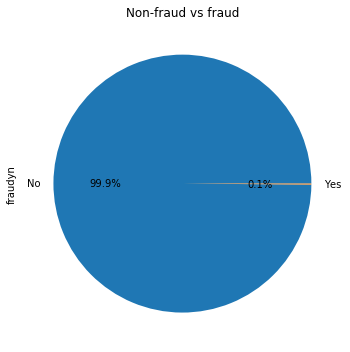

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt   

def plot_positive_negative_counts(df, target_col):
        df['fraudyn']=np.where(df[target_col]==1, 'Yes', 'No')
        df['fraudyn'].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f%%')
        plt.title('Non-fraud vs fraud')
        plt.tight_layout()
        del df['fraudyn']
    
plot_positive_negative_counts(df,target_col)

Check that target is on the left, per Sagemaker standard

In [9]:
assert target_col == df.columns.tolist()[0]

Transform hour of day to a form suited for cyclical data.

In [10]:
import numpy as np
hours_col = 'hourOf24_radians'
df['sineHourInDay'] = np.sin(df[hours_col])
df['cosineHourInDay'] = np.cos(df[hours_col])
df = df.drop(hours_col, axis=1)
df

,Fraudulent,type_CashIn,type_CashOut,type_Payment,type_Transfer,amount,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,sineHourInDay,cosineHourInDay
0,0,0,0,1,0,-0.281560,-0.229810,1,-0.237622,0.211876,-0.323814,-0.350732,-0.333411,0.258626,0.965977
1,0,0,0,1,0,-0.294767,-0.281359,1,-0.285812,0.157490,-0.323814,-0.352933,-0.333411,0.258626,0.965977
2,1,0,0,0,1,-0.297555,-0.288654,1,-0.292442,0.146011,-0.323814,-0.353398,-0.333411,0.258626,0.965977
3,1,0,1,0,0,-0.297555,-0.288654,1,-0.292442,0.146011,-0.317582,-0.347552,-0.333411,0.258626,0.965977
4,0,0,0,1,0,-0.278532,-0.274329,1,-0.282221,0.224345,-0.323814,-0.350227,-0.333411,0.258626,0.965977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,1,0,-0.291196,-0.233344,1,-0.239122,0.172195,-0.323814,-0.352338,-0.333411,0.501726,-0.865027
99996,0,0,0,1,0,-0.267474,-0.286568,1,-0.292442,0.187097,-0.323814,-0.348384,-0.333411,0.501726,-0.865027
99997,0,1,0,0,0,0.006480,-0.275154,1,-0.216195,-1.108434,-0.307656,-0.287564,-0.333411,0.501726,-0.865027
99998,0,0,1,0,0,-0.161668,-0.286628,1,-0.292442,0.185904,-0.149467,-0.167176,-0.115907,0.501726,-0.865027


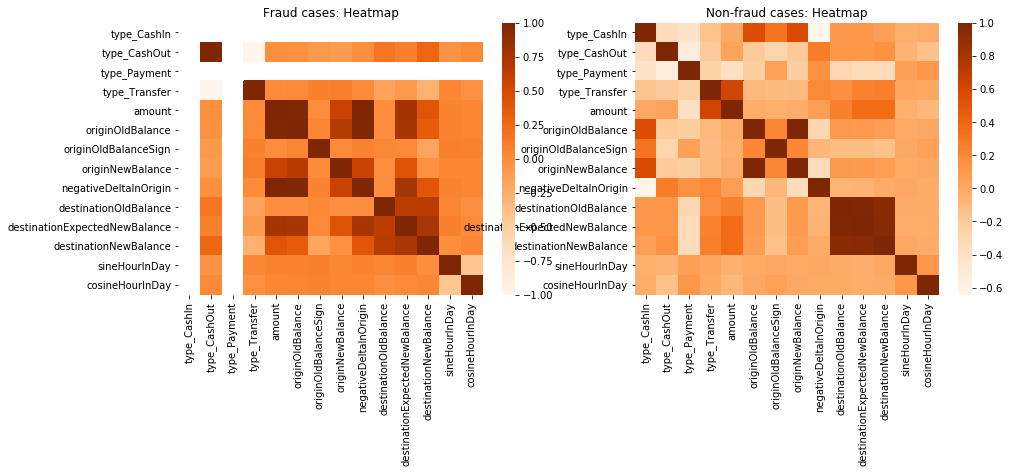

In [11]:
import seaborn  

fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl='Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'{target_col} == {fraud_cases}').drop([target_col], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost scaling parameters that accomplish the same thing.

In [12]:
%%time 

from imblearn.over_sampling import SMOTENC

use_smote = False # Can just use weighting in XGBOOST instead of SMOTENC

if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

CPU times: user 152 ms, sys: 15.6 ms, total: 167 ms
Wall time: 165 ms


# Split  with randomization

Using libSVM for performance.

In [84]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac
import os

In [85]:
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]

train_y = ( data_train.iloc[:,1]  ).to_numpy();
train_X = data_train.iloc[:,2:].to_numpy();

val_y = ( data_val.iloc[:,1]  ).to_numpy();
val_X = data_val.iloc[:,2:].to_numpy();

test_y =  (data_test.iloc[:,1]  ).to_numpy();
test_X = data_test.iloc[:,2:].to_numpy();

In [86]:
train_file = 'linear_train.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)

In [74]:
validation_file = 'linear_validation.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [77]:
%%time
import time
if not xgboost:
    from sagemaker.amazon.amazon_estimator import get_image_uri
    container = get_image_uri(boto3.Session().region_name, 'linear-learner')
    linear_job = 'DEMO-linear-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

    print("Job name is:", linear_job)
 
    linlearn = sagemaker.estimator.Estimator(container,
                                        role, 
                                        base_job_name='fraud-detection-job',
                                        train_instance_count=1, 
                                        train_instance_type='ml.m4.xlarge',
                                        output_path=s3_pth('output'),
                                        sagemaker_session=session,
                                        content_type='text/csv' ,
                                        predictor_type='binary_classifier',
                                        binary_classifier_model_selection_criteria='f1')
 
    positives_in_training_data, negatives_in_training_data=count_positive_and_negative(train_data)
    scale_pos_weight =  (negatives_in_training_data / positives_in_training_data )
    print(f'positives_in_training_data: {positives_in_training_data}, negatives_in_training_data: {negatives_in_training_data}, scale_pos_weight {scale_pos_weight:.1f}')
    feature_dim= len(df.columns)-1
    print('feature_dim', feature_dim)
    linlearn.set_hyperparameters(
            feature_dim=feature_dim,
            mini_batch_size=100,
            predictor_type= "regressor",
            epochs= 10,
            num_models= 32,
            loss= "absolute_loss",
            train_volume_size = 20,
            train_max_run = 3600)
    

    result = linlearn.fit({'train':  s3_path('train'), 'validation':  s3_path('validation')})
    training_job_name = linlearn._current_job_name

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Job name is: DEMO-linear-2020-11-22-15-37-52
s3://sagemaker-jfox/sagemaker/linearlearner/output
positives_in_training_data: 73, negatives_in_training_data: 69927, scale_pos_weight 957.9
feature_dim 14
s3://sagemaker-jfox/sagemaker/linearlearner/train
s3://sagemaker-jfox/sagemaker/linearlearner/validation
2020-11-22 15:37:52 Starting - Starting the training job...
2020-11-22 15:37:54 Starting - Launching requested ML instances......
2020-11-22 15:39:01 Starting - Preparing the instances for training......
2020-11-22 15:40:00 Downloading - Downloading input data...
2020-11-22 15:40:44 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script

2020-11-22 15:41:22 Uploading - Uploading generated training model
2020-11-22 15:41:22 Failed - Training job failed
[11/22/2020 15:41:10 INFO 140535996798784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.

UnexpectedStatusException: Error for Training job fraud-detection-job-2020-11-22-15-37-52-150: Failed. Reason: ClientError: No iterator has been registered for ContentType (u'csv', '1.0')

---
## Host

Deploy the trained model to an endpoint.

In [73]:
import datetime 
import time

endpoint_name = 'fraud-detect-endpoint'
model_name = training_job_name + '-model'

info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(
      name = model_name,
      role = role,
      container_defs = primary_container)


endpoint_config_name = session.create_endpoint_config(name=endpoint_name + '-config-' + datetime.datetime.now().strftime('%m%d-%H%M%S'),
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
counter = 0
try_now = True
while try_now:
  counter += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     if 'Could not find endpoint'  in str(e):
        print('Could not find endpoint; Trying to create')
        updated_endpoint=client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif 'Cannot update in-progress endpoint' in str(e):
        print(f'{counter} min: Cannot update in-progress endpoint; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

endpt_status = 'Updating'
minutes_passed = 0 
while endpt_status in ['Updating', 'Creating']:
    minutes_passed += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{minutes_passed} min: {endpt_status} endpoint; ',end='')
    time.sleep(30)

print('\nFinished creating or updating endpoint')

NameError: name 'training_job_name' is not defined

In [ ]:
from sagemaker.predictor import csv_serializer
from sagemaker.serializers import LibSVMSerializer


xgb_predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, 
    serializer=LibSVMSerializer(),
    sagemaker_session=sagemaker.Session()
)


---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [ ]:
def batch_predict(data, batch_size):

    def do_predict(data):
       payload = '\n'.join(data)
       response = xgb_predictor.predict(payload).decode('utf-8')
       result = response.split(',')
       preds = [float(num) for num in result]
       preds = [round(num) for num in preds]
       return preds

    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [ ]:
%%time
import json

with open('test.'+datatype_extension, 'r') as f:
    payload = f.read().strip()

labels_ml = [int(line.split(' ')[0]) for line in payload.split('\n')]

test_data_input_for_ml = [line for line in payload.split('\n')]
preds_ml = batch_predict(test_data_input_for_ml, 100)

In [ ]:
#labels_rule_based = list(test_data_for_rules[target_col])
#unexpected_pos = [lbl for lbl in labels_rule_based if lbl!=0 ]
#assert 0 == len(unexpected_pos), 'Expect all to be negative for these "types"'
#preds_rule_based = labels_rule_based.copy()

In [ ]:
#labels_all = labels_ml + labels_rule_based
#preds_all = preds_ml + preds_rule_based

In [ ]:
def metrics(labels_, predictions):
   assert len(labels_)==len(predictions)
   
   print(f'n = {len(labels_)}')
  
   actual_pos = sum(1 for i in range(len(labels_)) if 1 == labels_[i])
   actual_neg = sum(1 for i in range(len(labels_)) if 0 == labels_[i])

   pred_pos = sum(1 for i in range(len(predictions)) if 1 == predictions[i])
   pred_neg = sum(1 for i in range(len(predictions)) if 0 == predictions[i])

   true_pos = sum(1 for i in range(len(predictions)) if predictions[i] == 1 == labels_[i])
   true_neg = sum(1 for i in range(len(predictions)) if predictions[i] == 0 == labels_[i])

   false_pos=sum(1 for i in range(len(predictions)) if predictions[i] == 1 and 0 == labels_[i])
   false_neg=sum(1 for i in range(len(predictions)) if predictions[i] == 0 and 1 == labels_[i])
   
   print('true_pos', true_pos, 'false_pos', false_pos)
   print('true_neg', true_neg, 'false_neg', false_neg)

   assert  true_pos+false_pos == pred_pos
  
   recall = true_pos / (true_pos + false_neg)
   print(f'Recall = {recall:.2f}')
   precision = true_pos / (true_pos + false_pos)

   print(f'Precision = {precision:.2f}')
   if precision+recall == 0:
       f1=float('inf')
   else:
       f1 = (2 * precision * recall) / (precision + recall)
       
   print(f'F1 = {f1:.2f}')
   error = sum(1 for i in range(len(predictions)) if predictions[i] != labels_[i]) / float(len(predictions))
   print(f'Error rate = {error:.2f}')

   assert recall <= f1 <= precision or precision <= f1 <= recall  or precision==recall==0
   assert true_pos + false_neg == actual_pos
   assert true_neg + false_pos == actual_neg
   assert len(predictions)==len(labels_)
   assert actual_pos + actual_neg==len(labels_)
   assert true_neg + false_neg== pred_neg
   assert pred_pos + pred_neg==len(predictions)

print('ML-based metrics')
metrics(labels_ml, preds_ml)
#print('Full  metrics') 
#metrics(labels_all, preds_all)

Show confusion matrix.

In [ ]:
pd.crosstab(index=np.array(labels_all), columns=np.array(preds_all), rownames=['actual fraud'],  colnames=['predicted as fraud'])

Clean up to save money

In [ ]:
#session.delete_endpoint(xgb_predictor.endpoint)